# Rodrigo Lopez de Toledo

## En la práctica, además de funciones incluidas en el código original, he añadido algunas funcionalidades. Por ejemplo: Un analisis de intervenciones además de los mensajes y, también un analisis de las conversaciones, cuando los mensajes se contestan en menos de 30 minutos. Además un contador de archivos especificos como imagenes, videos, audios y stickers, además de mensajes eliminados

In [1]:
import io
import sys
import os
import re
import errno
import pandas as pd
import emoji
import unidecode
from collections import Counter
from dateutil import parser
import operator
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.graph_objects as go
%matplotlib inline


Bad key savefig.frameon in file /Users/rodrigolopezdetoledo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/rodrigolopezdetoledo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/rodrigolopezdetoledo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout

In [2]:
def replace_bad_character(line):
    return line.strip().replace(u"\u202a", "").replace(u"\u200e", "").replace(u"\u202c", "").replace(u"\xa0", " ")

### En vez de usar un archivo es_cw.py, he usado un .txt que es mas facil y rapido de manipular ya que es_cw.py no quita todas las palabras que no queremos.

In [3]:
#from stop_words import get_stop_words
import nltk
#from nltk.corpus import stopwords
nltk.download('stopwords')
    
def replace_bad_character(line):
    return line.strip().replace(u"\u202a", "").replace(u"\u200e", "").replace(u"\u202c", "").replace(u"\xa0", " ")

try: 
    filepath = raw_input("Please input the chat filepath: ")
except NameError:
    filepath = input("Please input chat filepath: ")

try:
    with io.open(filepath, "r", encoding="utf-8") as file:
        content = [replace_bad_character(l) for l in file.readlines()]
        file.close()
    
except IOError as e:
    print("File \"" + filepath + "\" not found. Please recheck your file location")
    sys.exit()

common_words = []
cw_filepath = ""

cw_option = "Please select common word file or leave it blank to escape: \n\
    1: Indonesian (id_cw.py)\n\
    2: English (en_cw.py)\n\
    3: Custom file\n\
    4: Spanish\n\
    5: Skip\n"
    
try: 
    cw = raw_input(cw_option)
except NameError:
    cw = input(cw_option)
    
if cw == "1":
    cw_filepath = "id_cw"
elif cw == "2":
    cw_filepath = "en_cw"
elif cw == "3":
    """
    Prompt user to input the file path
    """
    try: 
        cw_filepath = raw_input("Please input your common word filepath: ")
    except NameError:
        cw_filepath = input("Please input your common word filepath: ")

elif cw == "4":
    spanish=[]
    with open('stop_words_spanish.txt', 'r') as f:
        for line in (f.readlines()):
            spanish.append(line.replace("\n",""))
            #print(line)
    common_words = spanish
print(cw)
if len(cw_filepath) > 0 and cw != 4:

    try:
        common_words = __import__(cw_filepath, globals(), locals(), [common_words]).common_words
        
    except:
        print("Error getting common word file location")
        sys.exit()
else:
    print("You skipped common word.")

try: 
    verbose = raw_input("You wanna print the verbose mode? y/[N]: ") == "y" or False
except NameError:
    verbose = input("You wanna print the verbose mode? y/[N]: ") == "y" or False

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rodrigolopezdetoledo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Please input chat filepath:  glotones.txt
Please select common word file or leave it blank to escape: 
    1: Indonesian (id_cw.py)
    2: English (en_cw.py)
    3: Custom file
    4: Spanish
    5: Skip
 4


4
You skipped common word.


You wanna print the verbose mode? y/[N]:  N


In [4]:
"""
Starting line mean a line that started with date time.
Because there are multiline chat. I called it following line.
A starting line must be classified before it's data being extracted.
"""
def is_starting_line(line):
    pattern = r"""
        (\[?)       #Zero or one open square bracket '['
        (((\d{1,2})   #1 to 2 digit date
        (/|-)       #'/' or '-' separator
        (\d{1,2})   #1 to 2 digit month
        (/|-)       #'/' or '-' separator
        (\d{2,4}))   #2 to 4 digit of year
        (,?\s)      #Zero or one comma ',' and ingle space
        ((\d{1,2})  #1 to 2 digit of hour
        (:|\.)      #Colon ':' or dot '.' separator
        (\d{2})     #2 digit of minute
        (\.|:)?     #Zero or one of dot '.' or colon ':'
        (\d{2})?    #Zero or one of 2 digits of second
        (\s[AP]M)?))  #Zero or one of ('space', 'A' or 'P', and 'M'
        (\]?\s-?\s?\s?)#Zero or one close square bracket ']', Zero or one (space and '-'), zero or one space
        (.+)        #One or more character of chat member phone number or contact name
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), line)

"""
"Is Chat" means the body of a line is not an event.
May contains attachment
"""
def is_chat(body):
    pattern = r"""
            ([^:]+)#Chat member
            (:)   #Colon separator
            (.+)  #One or more charachter of message content
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), body)

def is_event(body):
    pattern_event = [
        "Messages to this group are now secured with end-to-end encryption\.$",
        ".+\screó este grupo$",
        ".+\skeluar$",
        ".+\sabandonó el grupo$",
        ".+\sabandonaste el grupo$",
        ".+\sañadio al grupo\s.+",
        ".+\seliminó\s.+",
        ".*You joined using this group's invite links$",
        ".+'s security code changed\.$",
        ".*changed their phone number to a new number. Tap to message or add the new number\.$"
    ]
    
    for p in pattern_event:
        match = re.match(p, body)
        if match:
            return match
    return None

"""
Deleted message
"""
def is_deleted(body):
    p = [
        ".*Este mensaje fue eliminado.\.$",
        ".*Este mensaje fue eliminado\.$",
        ".*Este mensaje fue eliminado$"
    ]
    
    for p in p:
        match = re.match(p, body)
        if match:
            return body
    return None

'''
check is message only consists of emojis
'''
def is_message_only_emoji(body):
    body_len = len(body.strip())
    emoji_count = 0
    for c in body:
        if c in emoji.UNICODE_EMOJI:
            emoji_count += 1
    if body_len == emoji_count:
        return True
    else:
        return False
    
"""
Has attachment
"""
def contains_attachment(body):
    pattern_attachment = [
        ".*<Media omitted>$", #English version of android attachment
        ".*<Media tidak disertakan>$", #Indonesia version of android attachment
        ".*Pesan tidak didukung$", #Some device not recognize sticker attachment
        ".+\.vcf \(file\sterlampir\)$", #Indonesian version of android contact card,
        ".+\.vcf \(file\sattached\)$", #Indonesian version of android contact card,
        ".*imagen omitida$",
        ".*video omitido$",
        ".*documento omitido$",
        ".*Tarjeta de contacto omitida$",
        ".*audio omitido$",
        ".*GIF omitido$",
        ".*sticker omitido$"
    ]
    
    for p in pattern_attachment:
        match = re.match(p, body)
        if match:
            return body
    return None

def increment_messages_counter(member):
    messages["member"].append(member)
    messages["messages_counter"].append(1)
    global total_chat
    total_chat += 1
    
    return member

"""
EXTRACT TIMESTAMP
"""
def extract_timestamp(time_string):
    return parser.parse(time_string)

def increment_message_is_emoji(member):
    emoji_only_message['member'].append(member)
    emoji_only_message['emoji_only_message_counter'].append(1)
    
    return member

def increment_emojis_counter(member, c):
    emojis["member"].append(member)
    emojis['emoji'].append(c)
    emojis["emojis_counter"].append(1)
    emojis["emj_char"].append(c[0])
    emojis["char_count"].append(c[1])
    
    return member

def increment_deleted_messages_counter(member):
    deleted_messages["member"].append(member)
    deleted_messages["deleted_messages_counter"].append(1)
    
    return member

from emoji import UNICODE_EMOJI
def is_emoji(s):
    count = 0
    for emoji in UNICODE_EMOJI:
        count += s.count(emoji)
    
    if count > 0:
        return 1
    else:
        return 0

def increment_attachment_counter(member, message):
    
    if member not in attachments.keys():
        attachments[member] = {
                       'imagenes': 0,
                       'videos': 0,
                       'audios': 0,
                       'documentos': 0,
                       'contactos': 0,
                       'gifs': 0,
                       'stickers': 0
                      }
    
    if "imagen omitida" in message:
        attachments[member]['imagenes'] += 1
        return
        
    if "video omitido" in message:
        attachments[member]['videos'] += 1
        return
    
    if "audio omitido" in message:
        attachments[member]['audios'] += 1
        return
    
    if "documento omitido" in message:
        attachments[member]['documentos'] += 1
        return
    
    if "Tarjeta de contacto omitida" in message or ".vcf" in message:
        attachments[member]['contactos'] += 1
        return
    
    if "GIF omitido" in message:
        attachments[member]['gifs'] += 1
        return
    
    if "sticker omitido" in message:
        attachments[member]['stickers'] += 1
        return
    
    ##Unknown attachment
    attachments[member]["unknown"] += 1
    
def rank_word(word):
    
    if not word in common_words:
        popular_words[word] = popular_words.get(word, 0) + 1
        global chat_words
        chat_words += " {0}".format(word)
        
    return word
    
"""
Counting function
"""

"""
Rank the 'Most Active user'
"""        
def increment_chat_count(member):
    member_chat["member"].append(member)
    member_chat["chat_count"].append(1)
    global total_chat
    total_chat += 1
    
    return member

def increment_heatmap(dt):
    heat_map["day"].append(dt.strftime("%A"))
    heat_map["hour"].append(dt.strftime("%H"))
    heat_map["chat_count"].append(1)
    
"""
Count top words
"""
def get_words(msg):
    
    #remove non alpha content
    regex = re.sub(r"[^a-z\s]+", "", msg.lower())
    regex = re.sub(r'[^\x00-\x7f]',r'', regex)
    words = regex.split(" ")
    
    for x in words:
        if x:
            rank_word(x)
            
    return words

"""
EMOJI
"""
def extract_emojis(sender,string):
    emj = []
    for c in string:
        if c in emoji.UNICODE_EMOJI:
            emj.append(c)

    if len(emj) > 0:
        increment_emojis_counter(sender,emj)
    
    return emj


In [5]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
"""
Global vars
"""
chat_of_members = {}
member_chat = {"member": [], "chat_count": []}
refered_web = {"domain": [], "d_count": []}
popular_words = {}
chat_words = ""
#emojis = {"emj_char": [], "char_count": []}
heat_map = {
    "day": [], 
    "hour": [], 
    "chat_count": []
}
deleted_message = 0
pure_chat = ""
total_chat = 0


### Ahora se parsea el contenido para quedarnos con los contadores y los datos que queremos

In [6]:
total_chat = 0

messages = {'member': [], 'messages_counter': []}
deleted_messages = {'member': [], "deleted_messages_counter": []}
emoji_only_message = {'member': [], 'emoji_only_message_counter': []}
emojis = {'member': [], 'emoji': [], "emojis_counter": [], "emj_char":[], "char_count":[]}
attachments = {}

from emoji import UNICODE_EMOJI
members = []

for line in content:
    # Check if line a starting line (because of multiline chat)
    is_starting = is_starting_line(line)
    
    if is_starting:
        # Take the body from the line
        body = is_starting.group(18)
        # Check if starting line is a message or an event
        chat = is_chat(body)
        
        
        if chat:
            has_attachment = contains_attachment(chat.group(3))
            increment_chat_count(chat.group(1))
            #Get the sender
            #sender = unidecode.unidecode(chat.group(1)).strip()
            sender = chat.group(1)
            members.append(sender)
            
            #And the body
            message_body = chat.group(3)
            
            emjs = extract_emojis(sender,message_body)
                    
            if is_message_only_emoji(message_body):
                increment_message_is_emoji(sender)
                    
            if is_deleted(message_body):
                increment_deleted_messages_counter(sender)
            else:
                prefix = "+++"
                #Word Count & Wordcloud
                get_words(message_body)
                if verbose: print(bcolors.OKGREEN + bcolors.HEADER + prefix + line)
                
                
            if contains_attachment(message_body):
                increment_attachment_counter(sender, message_body)
                if verbose: print(bcolors.OKBLUE + bcolors.HEADER + prefix + line)
            
                
            increment_messages_counter(sender)
        elif is_event(body):
            prefix = "***"
                
            if verbose: print(bcolors.WARNING + prefix + line)
    else:
        prefix = "|||"
        
        #URL & Domain
        #urls = extract_url(line)
        #if urls:
        #    increment_link_count(urls)
        
        #Emoji    
        emjs = extract_emojis(sender,line)
        
        #Word Count & Wordcloud
        get_words(line)

        if verbose: print(bcolors.FAIL + prefix + line)

members_df = pd.DataFrame(members, columns = ["member"])           

### A continuacion, además de los dataframes que ya vienen generados, he añadido mas, uno para los mensajes eliminados, algunos contadores y un dataset con todos los mensajes completos

In [7]:
messages_df = (pd.DataFrame(messages)
                     .groupby(["member"])
                     .sum()
                     .sort_values(by = ['messages_counter'], ascending=False))

deleted_messages_df = (pd.DataFrame(deleted_messages)
                     .groupby(["member"])
                     .sum()
                     .sort_values(by = ['deleted_messages_counter'], ascending=False))


emojis_only_message = (pd.DataFrame(emoji_only_message)
        .groupby(['member'])
        .sum()
        .sort_values(by = ['emoji_only_message_counter'], ascending=False)
)

# Emojis info
emojis_df = (pd.DataFrame(emojis)
                     .groupby(["member"])
                     .sum()
                     .sort_values(by = ['emojis_counter'], ascending=False))

emojis_df.reset_index(level=0, inplace=True)

emojis_df_detail_by_member = (pd.DataFrame(emojis)
                     .groupby(["member", 'emoji'])
                     .sum()
                     .sort_values(by = ['emojis_counter'], ascending=False))

emojis_df_detail_by_emoji = (pd.DataFrame(emojis)
                     .groupby(['emoji'])
                     .sum()
                     .sort_values(by = ['emojis_counter'], ascending=False))


attachments_df = (pd.DataFrame(attachments).transpose())

"""
DataFrame
"""
chat_per_member = (pd.DataFrame(member_chat)
                     .groupby(["member"])
                     .sum()
                     .sort_values(by = ['chat_count'], ascending=False))

popular_words_df = sorted(popular_words.items(), key=operator.itemgetter(1), reverse=True)


"""
Hacer un dataset completo
"""

import pandas as pd
import re

def parse_file(text_file):
    '''Convert WhatsApp chat log text file to a Pandas dataframe.'''
    
    with open(text_file) as f:
        #data = [m.group(1).strip().replace('\n', ' ') for m in pat.finditer(f.read())]
        data=[replace_bad_character(l) for l in f.readlines()]

    member = []; message = []; datetime = []
    
    for row in data:

        # timestamp is before the first dash
        datetime.append(row.split("]")[0])

        # message content is after the first colon
        try:
            message.append(row.split(': ', 1)[1])
        except:
            message.append('')

    df = pd.DataFrame(zip(datetime, message), columns=['timestamp', 'message'])
    df['timestamp'] = pd.to_datetime(df.timestamp, format='[%d/%m/%y %H:%M:%S')
    
    return df

df_full = parse_file(filepath)

print("Done. You can run next cell.")

Done. You can run next cell.


In [8]:
df_final = messages_df.join([deleted_messages_df, emojis_only_message, attachments_df])
df_final = df_final.fillna(0)

df_final['Regular messages'] = df_final.iloc[:, 0] - df_final.iloc[:, 1:].sum(axis=1)

df_sum = df_final.sum()

In [9]:
"""
Ver los dataframes
"""

print("DF de mensajes: \n", messages_df)
print("=================================")
print("DF de mensajes eliminados: \n", deleted_messages_df)
print("=================================")
print("DF de atachments: \n", attachments_df)
print("=================================")
print("DF de chat de cada miembro: \n", chat_per_member)
print("=================================")
df_full = pd.merge(df_full, members_df, left_index=True, right_index=True)
print("DF completo: \n", df_full)

DF de mensajes: 
                          messages_counter
member                                   
Iñigo Bernaldo                       1049
Fede Perez Crespo                     521
Pablo Jimenez                         467
Pablo Arboleya                        401
Rodrigo Lopez De Toledo               295
Alex Valencia                         219
Glotones                                1
DF de mensajes eliminados: 
                 deleted_messages_counter
member                                  
Alex Valencia                          3
Iñigo Bernaldo                         1
DF de atachments: 
                          audios  contactos  documentos  gifs  imagenes  \
Fede Perez Crespo             0          0           0     0        18   
Pablo Jimenez                 5          0           0     0        17   
Pablo Arboleya                0          0           0     0         9   
Iñigo Bernaldo                2          0           0     0        16   
Alex Valencia        

In [10]:
df_final_without_index = df_final.copy()
df_final_without_index.reset_index(level=0, inplace=True)

In [11]:
other_than_texts = df_final.iloc[:,1:-1]

### Vemos el usuario que mas mensajes ha enviado

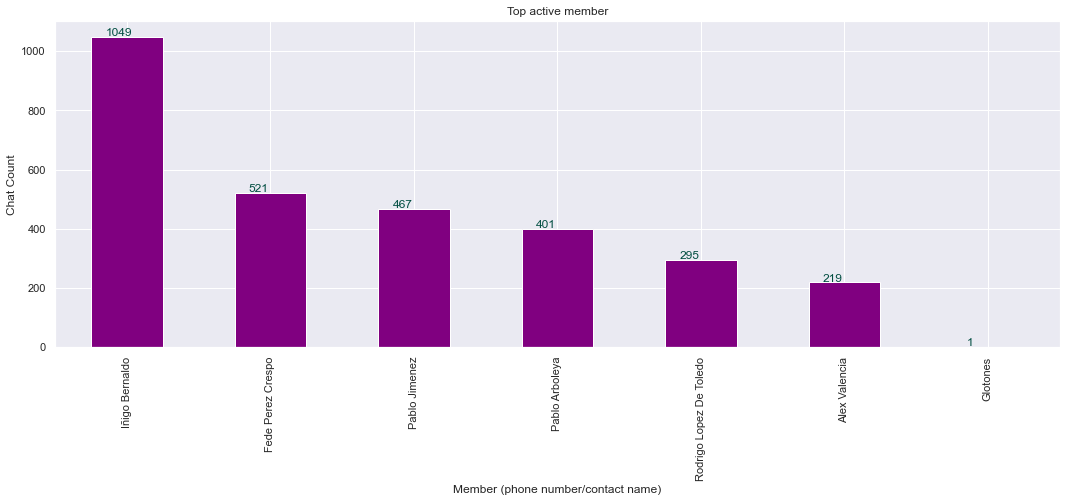

In [12]:
"""
Top Member Chat
"""
top_member = chat_per_member.head(20)
if not top_member.empty:
    sns.set()
    member_plot = top_member.plot(kind='bar', legend=None, title="Top active member", figsize=(18, 6), color="purple")
    member_plot.set_xlabel("Member (phone number/contact name)")
    member_plot.set_ylabel("Chat Count")
    for i, v in enumerate(top_member["chat_count"]):
        member_plot.text(i - .15, v + 3, v, color="#004d40")
else:
    print("This chat has no member")

### Vamos a filtrar y agrupar para ver las intervenciones reales, en vez de los mensajes totales. Como se pueden enviar varios mensajes seguidos, quiero ver el número de intervenciones, por ejemplo, 5 mensajes consecutivos de un mismo miembro es una intervencion.

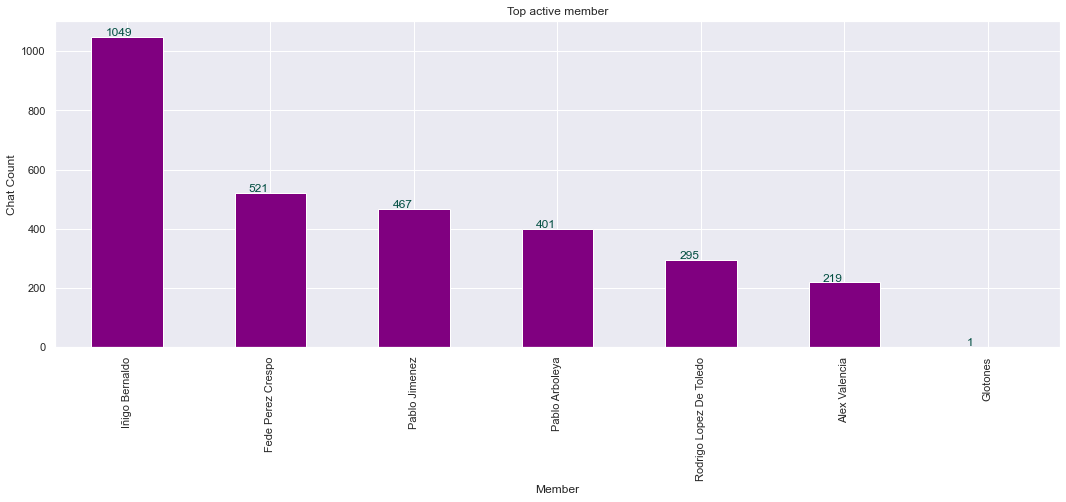

In [25]:
"""
Descartando los mensajes multilinea, vemos el numero real de intervenciones en el chat
"""
x = df_full.member.values

names = []; message_length = []
# generates a new group every time the value of the list changes
# https://docs.python.org/2/library/itertools.html#itertools.groupby

import itertools

for k, g in itertools.groupby(x):
    names.append(k)
    message_length.append(len(list(g)))
    
df2 = pd.DataFrame(zip(names, message_length), columns=['member', 'length'])
#print(df2)

top_member_clean = (df2
                     .groupby(["member"])
                     .sum().sort_values(by = ['length'], ascending=False))

#print(top_member_clean)

if not top_member_clean.empty:
    sns.set()
    member_plot = top_member_clean.plot(kind='bar', legend=None, title="Top active member", figsize=(18, 6), color="purple")
    member_plot.set_xlabel("Member")
    member_plot.set_ylabel("Chat Count")
    for i, v in enumerate(top_member_clean["length"]):
        member_plot.text(i - .15, v + 3, v, color="#004d40")
else:
    print("This chat has no member")


### Ahora cuento las palabras, caracteres y la proporcion de palabras por mensaje de cada usuario

                         characters  words    reply_time  conversation  \
member                                                                   
Iñigo Bernaldo                21645   4201           inf        157874   
Fede Perez Crespo             11382   2192  9.139232e+04         74174   
Pablo Jimenez                 10044   1915  7.885505e+04         60798   
Pablo Arboleya                 7925   1591  1.468811e+05         57350   
Rodrigo Lopez De Toledo        6430   1223  9.344362e+04         42480   
Alex Valencia                  5488   1049  6.574670e+04         36278   
Glotones                        142     23  0.000000e+00             1   

                         chat_count       prop  
member                                          
Iñigo Bernaldo                 1049   4.004766  
Fede Perez Crespo               521   4.207294  
Pablo Jimenez                   467   4.100642  
Pablo Arboleya                  401   3.967581  
Rodrigo Lopez De Toledo         295   4

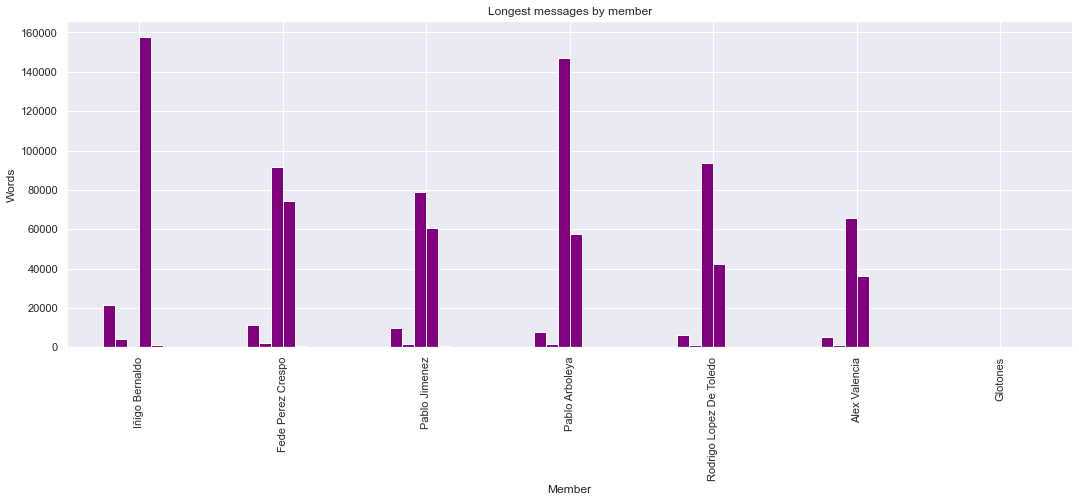

In [26]:
df_full['characters'] = df_full.message.apply(len)
df_full['words'] = df_full.message.apply(lambda x: len(x.split()))

#df_full.groupby('member').mean().sort_values('characters').round(2)
df_longest_messages = (df_full
                     .groupby(["member"])
                     .sum().sort_values(by = ['words'], ascending=False))

df_longest_messages = pd.merge(df_longest_messages, chat_per_member, left_index=True, right_index=True)
df_longest_messages['prop'] = df_longest_messages.words/df_longest_messages.chat_count
#df_full.join(members_df)
print(df_longest_messages)

if not df_longest_messages.empty:
    sns.set()
    words_plot = df_longest_messages.plot(kind='bar', legend=None, title="Longest messages by member", figsize=(18, 6), color="purple")
    words_plot.set_xlabel("Member")
    words_plot.set_ylabel("Words")
else:
    print("This chat has no member")

### Ahora, hago un estudio de las conversaciones, que las defino como mensajes respondidos en un espacio de 30 minutos. Obtengo el inicio de la conversacion, el final, el numero de mensajes en ella, el miembro que inicia la conversacion, los que participan en ella y su duracion.

In [27]:
# find time difference between current and previous message
df_convo = df_full
df_convo['reply_time'] = (df_convo.timestamp.shift(-1) - df_convo.timestamp).apply(lambda x: x.total_seconds()/60).fillna(np.inf)
# if reply time is more than 20 mins add 1 to counter
df_convo['conversation'] = (df_convo.reply_time > 30).cumsum().shift(1).fillna(0).astype(int) + 1

df3 = df_convo.groupby('conversation').agg({'timestamp': ['min', 'max', 'count'], 
                                      'member': ['first', 'unique', 'nunique']})

df3['duration'] = (df3['timestamp']['max'] - df3['timestamp']['min']).apply(lambda x: x.total_seconds()/60)

df3.head(20)

timestamp                            \
                             min                 max count   
conversation                                                 
1            2019-01-20 01:33:01 2019-01-20 01:33:01     2   
2            2019-09-17 17:11:08 2019-09-17 17:11:08     1   
3            2019-09-17 17:56:26 2019-09-17 18:02:09    30   
4            2019-09-18 12:29:35 2019-09-18 13:07:06    35   
5            2019-09-18 14:07:23 2019-09-18 14:26:02    17   
6            2019-09-18 16:37:46 2019-09-18 17:34:24    12   
7            2019-09-26 14:21:19 2019-09-26 14:49:18    15   
8            2019-09-30 15:06:27 2019-09-30 15:10:15    15   
9            2019-10-02 08:26:05 2019-10-02 08:53:07    18   
10           2019-10-02 13:13:46 2019-10-02 13:26:02    10   
11           2019-10-02 21:59:49 2019-10-02 22:00:39     2   
12           2019-10-02 23:27:34 2019-10-02 23:31:21     2   
13           2019-10-07 11:57:09 2019-10-07 11:57:09     1   
14           2019-10-09 11:37:01 2019-10-09 11:50:08    10   
15           2019-10-09 12:31:05 2019-10-09 12:31:59     3   
16           2019-10-09 14:32:16 2019-10-09 14:36:20     9   
17           2019-10-09 16:03:22 2019-10-09 16:03:22     1   
18           2019-10-14 21:02:16 2019-10-14 21:03:52    10   
19           2019-10-15 09:38:56 2019-10-15 09:38:59     2   
20           2019-10-15 10:39:36 2019-10-15 11:10:33    14   

                               member  \
                                first   
conversation                            
1                            Glotones   
2                      Iñigo Bernaldo   
3                   Fede Perez Crespo   
4                       Pablo Jimenez   
5                   Fede Perez Crespo   
6                   Fede Perez Crespo   
7                      Iñigo Bernaldo   
8             Rodrigo Lopez De Toledo   
9                      Iñigo Bernaldo   
10                     Iñigo Bernaldo   
11                     Iñigo Bernaldo   
12            Rodrigo Lopez De Toledo   
13                     Pablo Arboleya   
14                      Pablo Jimenez   
15                      Alex Valencia   
16                     Pablo Arboleya   
17                     Iñigo Bernaldo   
18                     Pablo Arboleya   
19                     Iñigo Bernaldo   
20                      Pablo Jimenez   

                                                                         \
                                                         unique nunique   
conversation                                                              
1                                    [Glotones, Iñigo Bernaldo]       2   
2                                              [Iñigo Bernaldo]       1   
3             [Fede Perez Crespo, Iñigo Bernaldo, Pablo Jime...       4   
4             [Pablo Jimenez, Iñigo Bernaldo, Rodrigo Lopez ...       5   
5             [Fede Perez Crespo, Pablo Jimenez, Iñigo Berna...       6   
6             [Fede Perez Crespo, Alex Valencia, Pablo Arbol...       6   
7             [Iñigo Bernaldo, Pablo Arboleya, Pablo Jimenez...       5   
8             [Rodrigo Lopez De Toledo, Fede Perez Crespo, I...       3   
9             [Iñigo Bernaldo, Pablo Arboleya, Rodrigo Lopez...       3   
10            [Iñigo Bernaldo, Pablo Jimenez, Pablo Arboleya...       4   
11                    [Iñigo Bernaldo, Rodrigo Lopez De Toledo]       2   
12                                    [Rodrigo Lopez De Toledo]       1   
13                                             [Pablo Arboleya]       1   
14            [Pablo Jimenez, Fede Perez Crespo, Pablo Arbol...       6   
15                               [Alex Valencia, Pablo Jimenez]       2   
16              [Pablo Arboleya, Iñigo Bernaldo, Pablo Jimenez]       3   
17                                             [Iñigo Bernaldo]       1   
18            [Pablo Arboleya, Fede Perez Crespo, Pablo Jime...       3   
19                                             [Iñigo Bernaldo]       1   
20

### Ahora hago un analisis estadistico donde se ve que la media de mensajes en cada conversacion es de 11 mensajes (La que mas son 180), la duracion media de las conversaciones son de 15 minutos y participan casi 3 miembros del grupo de media.

In [28]:
df3.describe()

,timestamp,member,duration
,count,nunique,
count,259.000000,259.000000,259.000000
mean,11.401544,2.888031,15.392278
std,20.723563,1.579610,34.390205
min,1.000000,1.000000,0.000000
25%,2.000000,1.000000,0.100000
50%,4.000000,3.000000,4.333333
75%,11.000000,4.000000,18.833333
max,180.000000,6.000000,451.233333


### En los siquientes gráficos se muestran la cantidad de mensajes de distintos tipos que manda cada miembro (Mensajes eliminados, imagenes, audios y stickers)

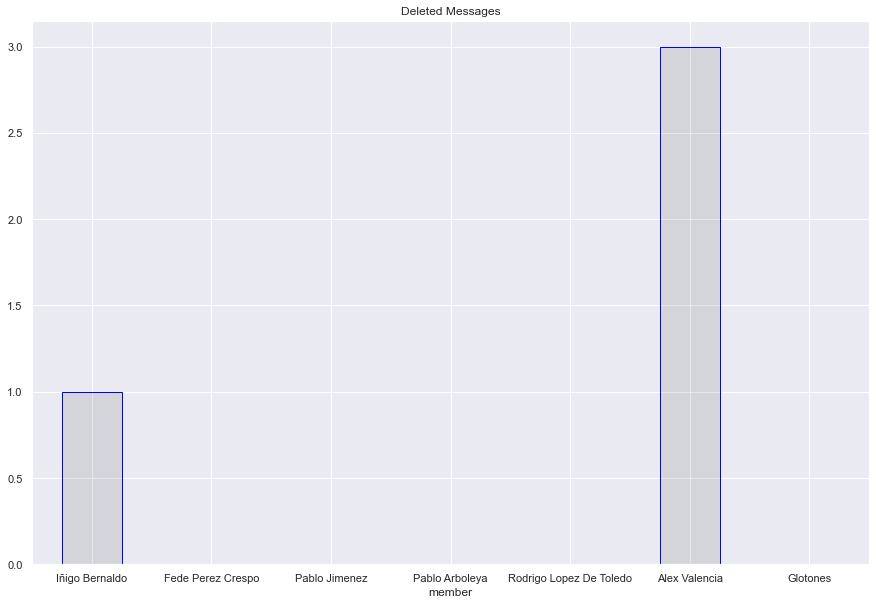

In [29]:
mpl.rcParams['figure.figsize'] = 15, 10

ax = df_final_without_index.plot.bar(x='member', y='deleted_messages_counter', rot=0, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax.get_legend().remove()
ax.title.set_text("Deleted Messages")

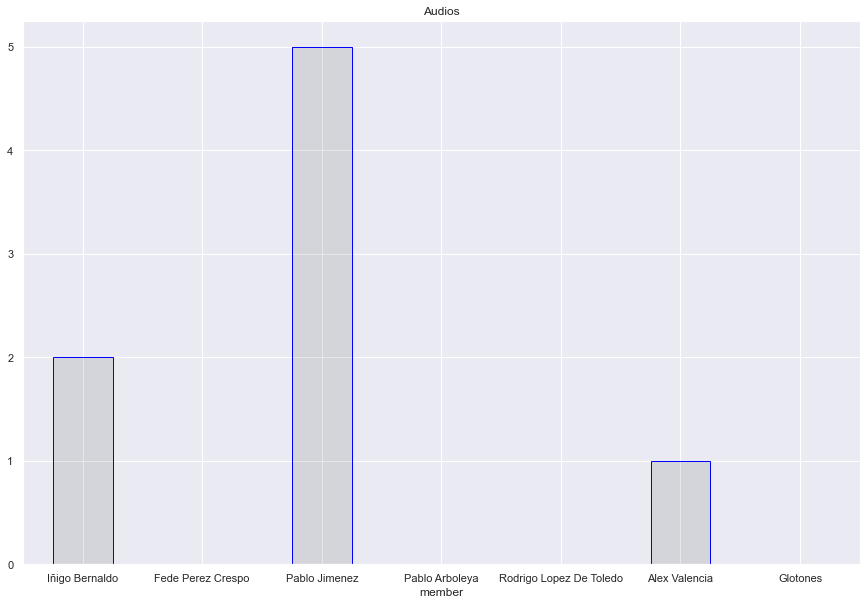

In [18]:
ax = df_final_without_index.plot.bar(x='member', y='audios', rot=0, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax.get_legend().remove()
ax.title.set_text("Audios")

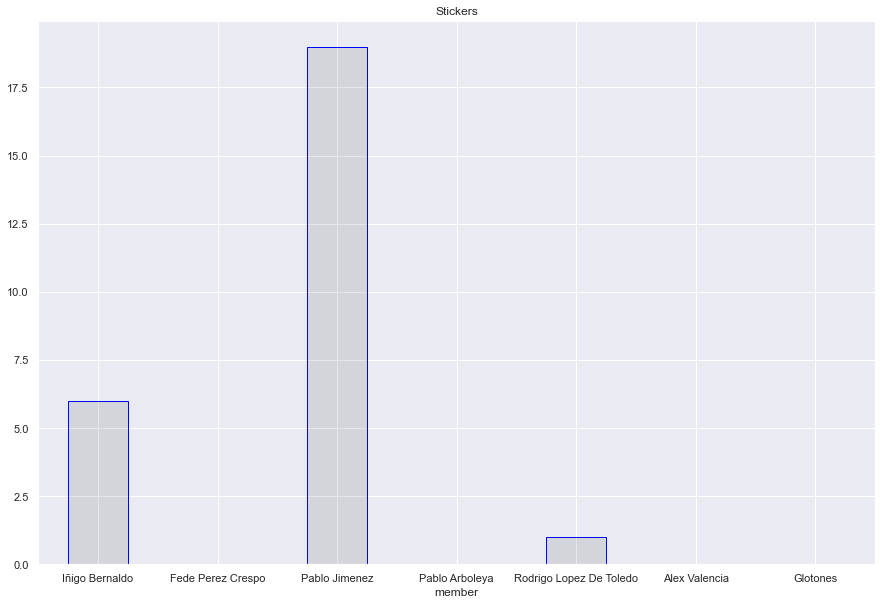

In [19]:
ax = df_final_without_index.plot.bar(x='member', y='stickers', rot=0, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax.get_legend().remove()
ax.title.set_text("Stickers")

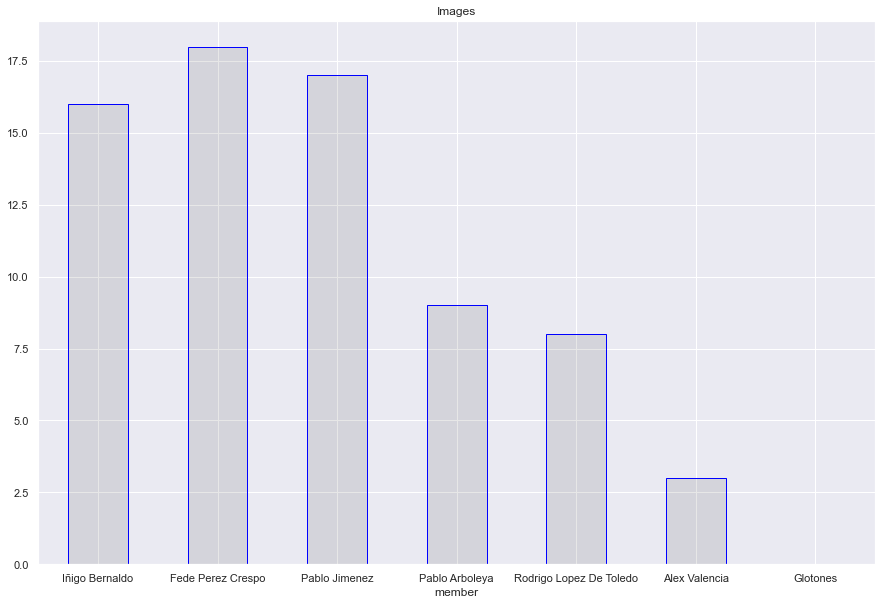

In [20]:
ax = df_final_without_index.plot.bar(x='member', y='imagenes', rot=0, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax.get_legend().remove()
ax.title.set_text("Images")

### Aqui deberia haber un estudio de los emojis usados por cada uno, pero por alguna razon no me funciona..., la librería no los detecta en el .txt no se porque...

In [21]:
ax = emojis_df.plot.bar(x='member', y='emojis_counter', rot=0, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax.get_legend().remove()
ax.title.set_text("Total Emojis Used")

In [22]:
emojis_df_detail_by_member.head(10)

,,emojis_counter,emj_char,char_count
member,emoji,,,


In [23]:
emojis_df_detail_by_emoji.head(10)

,member,emojis_counter,emj_char,char_count
emoji,,,,


### Por ultimo, un grafico de las palabras mas utilizadas

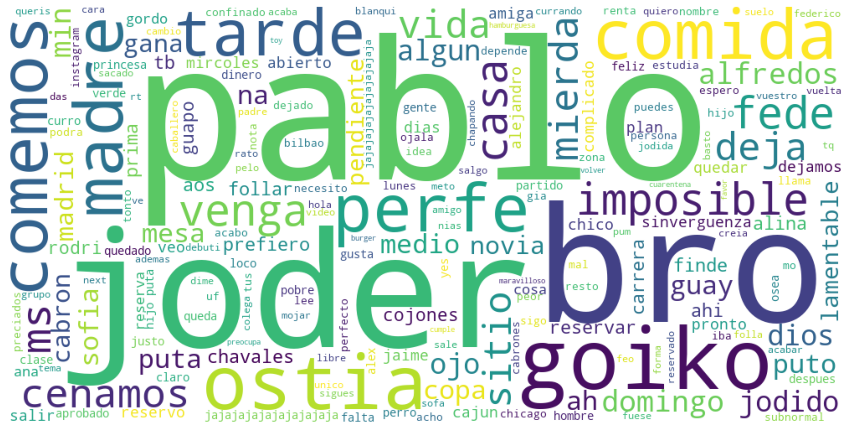

In [24]:
"""
Wordcloud
"""
if chat_words:
    wordcloud = WordCloud(
        width = 1000, 
        height = 500,
        background_color = "white"
    ).generate(chat_words)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
else:
    print("This chat contains no word")